# Import Library

In [3]:
import time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange, tqdm

import albumentations as A

In [4]:
import os 
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
#tf.config.experimental.set_memory_growth(gpus[0], True)

import nami

In [5]:
!nvidia-smi -L

GPU 0: GeForce RTX 3080 (UUID: GPU-a38dd65b-bdf5-159e-8b35-dd0c4396bd53)


# Import Dataset

In [6]:
from nami.datasets.kme import load_data
(image_train, caption_train), (image_test, caption_test) = load_data(test_size = 0.3)

In [7]:
print(image_train.shape)
print(image_test.shape)

(660, 256, 256, 3)
(283, 256, 256, 3)


## Preprocessing Dataset

In [8]:
from nami.AI.kme_tokenize import Tokenizer
tokenizer = Tokenizer()

In [9]:
tokenizer.fit_on_texts(caption_train)

In [10]:
text2seq_train = tokenizer.text_to_sequences(caption_train)
seq2text_train = tokenizer.sequences_to_text(text2seq_train)

In [11]:
text2seq_test = tokenizer.text_to_sequences(caption_test)
seq2text_test = tokenizer.sequences_to_text(text2seq_test)

## Hyperparameter

In [12]:
BATCH_SIZE = 16
BUFFER_SIZE = 1000
units = 512
vocab_size = len(tokenizer.word2index)

IMG_SIZE = 256
IMG_SHAPE = (256, 256, 3)

num_steps_train = len(image_train) // BATCH_SIZE
num_steps_test = len(image_test) // BATCH_SIZE

max_length_train = text2seq_train.shape[1]
max_length_test = text2seq_test.shape[1]

encoding_size = 512 # Determines dimension of the encodings of images
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Create Dataset

## Augmentation

In [60]:
transforms = A.Compose([
            #A.ShiftScaleRotate(shift_limit=0.1, scale_limit=[-0.2, 0.2], rotate_limit=45, p=0.9, border_mode=1),
            #A.GaussNoise(var_limit=(0, 225), p= 0.9),
            # A.Blur(blur_limit= 3, p= 0.5),
            # HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            #A.Flip(p= 0.5), A.Transpose(p= 0.5),
            #A.ToGray(p= 0.3),
            #A.ChannelShuffle(p= 0.5),
            #A.RandomBrightness(limit=(-0.10, 0.0), p= 0.5)
            

        ])

In [61]:
def aug_fn(image, img_size):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    #aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    return aug_img

In [62]:
def process_data(image, label, img_size=IMG_SIZE):
  aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
  return aug_img, label

In [63]:
def set_shapes(img, label, img_shape=IMG_SHAPE):
    img.set_shape(img_shape)
    #label.set_shape([])
    return img, label

## Tf.data.Dataset

In [64]:
from functools import partial

dataset = tf.data.Dataset.from_tensor_slices((image_train, text2seq_train))
print(dataset)
dataset = dataset.map(partial(process_data, img_size=IMG_SIZE),
                  num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
print(dataset)
dataset = dataset.map(set_shapes, num_parallel_calls=AUTOTUNE).shuffle(1000).batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)
print(dataset)

<TensorSliceDataset shapes: ((256, 256, 3), (37,)), types: (tf.uint8, tf.int32)>
<PrefetchDataset shapes: (<unknown>, (37,)), types: (tf.float32, tf.int32)>
<PrefetchDataset shapes: ((None, 256, 256, 3), (None, 37)), types: (tf.float32, tf.int32)>


In [65]:
dataset_val = tf.data.Dataset.from_tensor_slices((image_test, text2seq_test)).batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)
dataset_val

<PrefetchDataset shapes: ((None, 256, 256, 3), (None, 58)), types: (tf.uint8, tf.int32)>

## Plot Augmentation

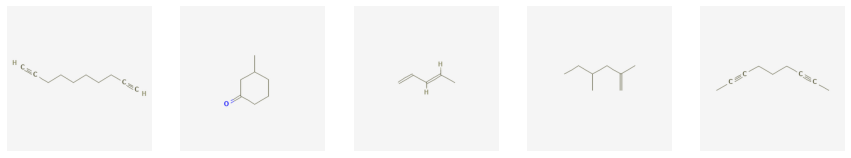

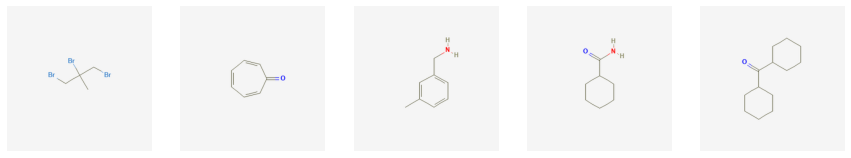

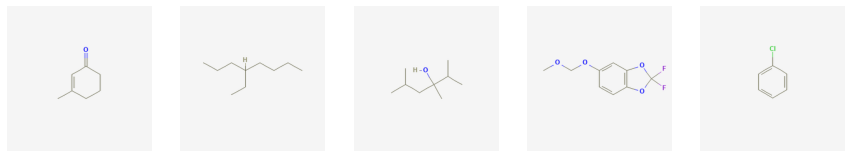

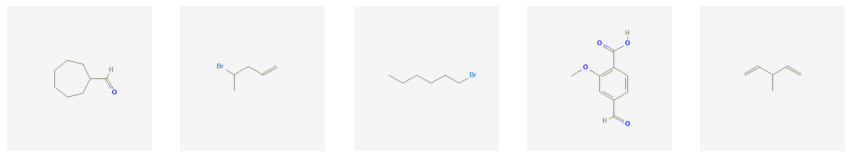

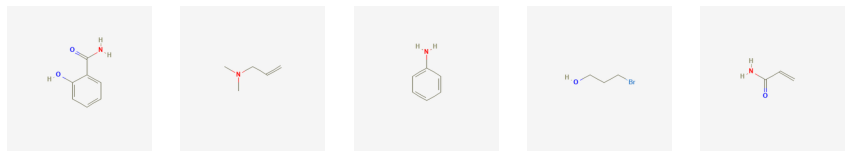

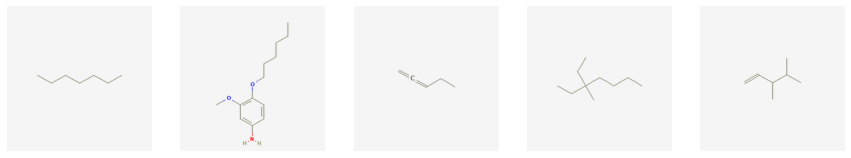

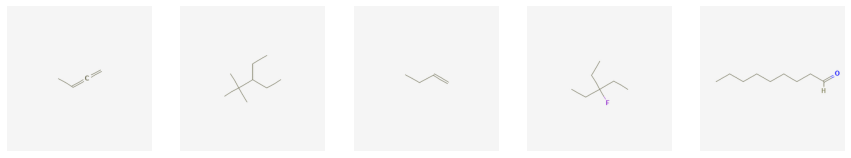

In [66]:
# Test parameter of ImageDataGenerator
for index, (img, label) in enumerate(dataset):
  plt.figure(figsize=(15, 15))
  for i in range(1, 6):
    plt.subplot(1, 5, i)
    plt.imshow( tf.cast(img[i], tf.uint8) )
    plt.axis('off')
  plt.show()
  if index == 6:
    break

# Model Architecture

## Efficientnet-B7

In [20]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0

pret_model = EfficientNetB0(include_top = False, weights='imagenet', input_shape=IMG_SHAPE)

pret_model.trainable = True

attention_features_shape = 8 * 8
features_shape = 1536

# Xception : [7, 7, 2048]
# InceptionResNetV2 : [5, 5, 1536]
# EfficientNetB0 : [7, 7, 2560]

In [21]:
tf.keras.utils.plot_model(pret_model, show_shapes = True, dpi = 46)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


## CNN Encoder (Encoder output of feature extraction)

In [22]:
from tensorflow.keras.models import Sequential

def create_encoder():
  x = tf.keras.layers.Dense(encoding_size,activation='relu',name="encoding_layer")(pret_model.output)
  output = tf.keras.layers.Reshape(target_shape=(attention_features_shape, encoding_size))(x)
  return tf.keras.Model(pret_model.input, output)

In [23]:
encoder = create_encoder()

In [24]:
tf.keras.utils.plot_model(encoder, show_shapes = True, dpi = 46)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


## Luong Attention

In [25]:
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM

In [26]:
def create_attention(features, hidden, method = 'concat'):
  # features(CNN_encoder output) shape == (batch_size, 25, embedding_dim)
  # hidden shape == (batch_size, hidden_size)
  
  # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
  hidden_with_time_axis = tf.expand_dims(hidden, 1)
  
  if method == 'concat':
    attention_hidden_layer = tf.nn.tanh( Dense(units)(features + hidden) )
  elif method == 'general':
    attention_hidden_layer = tf.matmul( features, Dense(units)(hidden), transpose_b=True )
  elif attention_hidden_layer == 'dot':
    attention_hidden_layer = tf.matmul( features, hidden, transpose_b=True )
  
  score = Dense(1)(attention_hidden_layer)
  attention_weights = tf.nn.softmax(score, axis=1)

  context_vector = attention_weights * features
  context_vector = tf.reduce_sum(context_vector, axis=1)
  
  return context_vector, attention_weights

## Create RNN Decoder

In [27]:
def create_decoder():
  features = tf.keras.layers.Input((attention_features_shape, encoding_size))
  dec_input= tf.keras.layers.Input((1))
  hidden = tf.keras.layers.Input((units))

  embedded = Embedding(vocab_size, encoding_size)(dec_input)

  lstm_output, state = GRU(units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')(embedded, initial_state=[hidden])
 
  context_vector, attention_weights = create_attention(features, lstm_output)

  # embedded shape after concatenation == (batch_size, 1, encoding_size + hidden_size)
  output = tf.concat([context_vector, tf.squeeze(embedded, 1)], axis = -1)
  
  # shape == (batch_size, hidden_size)
  output = Dense(units, activation='tanh')(output)

  output = Dense(vocab_size, activation = 'softmax')(output)

  return tf.keras.models.Model([features, dec_input, hidden], [output, state, attention_weights])

def reset_state(batch_size):
  return tf.zeros((batch_size, units))

In [28]:
decoder = create_decoder()

tf.keras.utils.plot_model(decoder, show_shapes=True, dpi = 49)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


# Custom Loss Function


In [29]:
def loss_fn(real, pred):
  # Word Loss

  real_onehot = tf.one_hot(tf.cast(real, tf.uint8), vocab_size)

  loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction = 'none', label_smoothing=0.2)
  mask = tf.math.logical_not(tf.math.equal(real, tokenizer.word2index['<pad>'])) # make padding element -> true(1) -> false (0)
  loss_ = loss_object(real_onehot, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  # EOS Loss
  loss_object2 = tf.keras.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0.2)

  end_token = tokenizer.word2index['<end>']
  pred_id = tf.math.argmax(pred, axis=-1)

  real_eos = tf.cast(tf.math.equal(real, end_token), dtype=tf.float32)
  pred_eos = tf.cast(tf.math.equal(pred_id, end_token), dtype=tf.float32)

  loss_2 = loss_object2(real_eos, pred_eos)

  return tf.reduce_mean(loss_) + loss_2 

# Metrics

## NLTK

In [30]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

class Bleu(tf.keras.metrics.Metric):
  def __init__(self, name='bleu', **kwargs):
    super(Bleu, self).__init__(name=name, **kwargs)
    self.score = self.add_weight(name='score', initializer='zeros')
    self.count = self.add_weight(name='count', initializer='zeros')
    self.chencherry = SmoothingFunction()

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_true = y_true[y_true != tokenizer.word2index['<pad>']]
    idx = np.where(y_pred == tokenizer.word2index['<end>'])[0]

    if idx != []:
      y_pred = y_pred[:idx[0]+1]
          
    values = sentence_bleu([y_true], y_pred, smoothing_function=self.chencherry.method4)

    self.count.assign_add(1)
    self.score.assign_add(values)

  def result(self):
    return self.score / self.count

  def reset_states(self):
    self.count.assign(0)
    self.score.assign(0)

# Callback

In [31]:
class EarlyStopping():
  def __init__(self, monitor = 'val_bleu', mode = 'max', patience = 1, encoder = encoder, decoder = decoder):
    if mode == 'max':
      self.mode = 'max'
      self.best = -100
    else: # Min
      self.min = 'min'
      self.best = 100
    self.patience = patience
    self.wait = 0
    self.encoder = encoder
    self.decoder = decoder

  def callback(self, log, epoch):
    if self.mode == 'max':
      if log < self.best:
        self.wait += 1
        if self.wait > self.patience:
          print('EarlyStopping : {} < best {} '.format(log, self.best))
          return True
      else :
        self.wait = 0
        self.best = log
        self.encoder.save('Luong_model/Encoder_model.h5', include_optimizer=False)
        self.decoder.save('Luong_model/Decoder_model.h5', include_optimizer=False)
        print('Save Model Succesful')
    else:
      if log > self.best:
        self.wait += 1
        if self.wait > self.patience:
          print('EarlyStopping : {} > best {} '.format(log, self.best))
          return True
      else :
        self.wait = 0
        self.best = log
        self.encoder.save('Luong_model/Encoder_model.h5', include_optimizer=False)
        self.decoder.save('Luong_model/Decoder_model.h5', include_optimizer=False)
        print('Save Model Succesful')
    
    return False
  

In [32]:
earlystop = EarlyStopping(patience = 7)

# Training Model

In [33]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.0001, decay_steps = 10000, decay_rate=0.96, staircase=True, name=None
)
opt = tf.keras.optimizers.Adam(lr_schedule)

train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
val_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')
bleu = Bleu()
bleu_val = Bleu()

## Train Step

In [34]:
@tf.function
def train_step(img_tensor, target):
  batch_size = tf.shape(img_tensor)[0]

  hidden_state = reset_state(batch_size = batch_size)
  decoder_input = tf.ones([batch_size, 1])
  dec_train_pred = tf.ones([batch_size, 1], dtype=tf.int32)

  loss = 0 
  
  with tf.GradientTape() as tape:
    img_feature = encoder(img_tensor, training = True)

    for i in range(1, max_length_train):
      # passing the features through the decoder
      predictions, hidden_state, _ = decoder([img_feature, decoder_input, hidden_state], training = True)
      loss += loss_fn(target[:,i], predictions)
      
      predict_ids = tf.argmax(predictions, axis = -1, output_type= tf.int32)
      predict_ids = tf.reshape(predict_ids, (-1, 1))
      dec_train_pred = tf.concat( [dec_train_pred, predict_ids], axis = -1 )
      # using teacher forcing
      decoder_input = tf.expand_dims(target[:, i], 1)
      # Metrics
      mask = tf.math.logical_not(tf.math.equal(target[:, i], tokenizer.word2index['<pad>']))
      mask = tf.cast(mask, tf.float32)
      train_acc.update_state(target[:, i], predictions, sample_weight = mask)

  gradient = tape.gradient(loss, encoder.trainable_variables + decoder.trainable_variables) 
  opt.apply_gradients(zip(gradient, encoder.trainable_variables + decoder.trainable_variables))

  return {'pred': dec_train_pred, 'loss': loss / max_length_train, 'acc' : train_acc.result()}

## Test Step

In [35]:
@tf.function
def test_step(img_tensor, target):
  batch_size = tf.shape(img_tensor)[0]

  hidden_state = reset_state(batch_size = batch_size)
  decoder_input = tf.ones([batch_size, 1])
  dec_val_pred = tf.ones([batch_size, 1], dtype=tf.int32)

  loss = 0

  with tf.GradientTape() as tape:  
    img_feature = encoder(img_tensor, training = False)

    for i in range(1, max_length_test):
      predictions, hidden_state, _ = decoder([img_feature, decoder_input, hidden_state], training = False)
      loss += loss_fn(target[:,i], predictions)

      predict_ids = tf.argmax(predictions, axis = -1, output_type= tf.int32)
      predict_ids = tf.reshape(predict_ids, (-1, 1))
      dec_val_pred = tf.concat( [dec_val_pred, predict_ids], axis = -1 )
        
      decoder_input = tf.expand_dims(target[:, i], 1)

      # Metrics
      mask = tf.math.logical_not(tf.math.equal(target[:, i], tokenizer.word2index['<pad>']))
      mask = tf.cast(mask, tf.float32)
      val_acc.update_state(target[:, i], predictions, sample_weight = mask)

  return {'pred': dec_val_pred, 'loss': loss/max_length_test, 'acc': val_acc.result()}

In [36]:
from IPython.display import clear_output, display

def fit(epochs, dataset, dataset_val, num_steps, num_steps_val):
  for epoch in trange(1, epochs+1):
    train_acc.reset_states()
    bleu.reset_states()

    for index, (image, caption) in tqdm(enumerate(dataset.take(num_steps)), total=num_steps, leave=False):
      monitor = train_step(image, caption)
  
      for i in range(tf.shape(caption)[0]):
        bleu.update_state(caption[i].numpy(), monitor['pred'][i].numpy())

    val_acc.reset_states()
    bleu_val.reset_states()

    for index, (image, caption) in tqdm(enumerate(dataset_val.take(num_steps_val)), total=num_steps_val, leave=False):
      monitor_val = test_step(image, caption)

      for i in range(tf.shape(caption)[0]):
        bleu_val.update_state(caption[i].numpy(), monitor_val['pred'][i].numpy())
            
    print(f'Epoch {epoch}/{epochs}\n'\
          f'loss : {(monitor["loss"].numpy()):.4f} acc : {(monitor["acc"].numpy()):.4f} bleu : {(bleu.result().numpy()):.4f} '\
          f'val_loss : {(monitor_val["loss"].numpy()):.4f} val_acc : {(monitor_val["acc"].numpy()):.4f} val_bleu : {(bleu_val.result().numpy()):.4f}'
    )

    if earlystop.callback(bleu_val.result().numpy(), epoch):
      break

    del monitor
    del monitor_val

## Fitting

In [37]:
fit(epochs = 50, dataset = dataset, num_steps = num_steps_train,
    dataset_val = dataset_val, num_steps_val = num_steps_test)

 24%|██▍       | 12/50 [03:37<11:27, 18.10s/it]


Epoch 1/50
loss : 3.0172 acc : 0.1952 bleu : 0.1048 val_loss : 2.5317 val_acc : 0.2097 val_bleu : 0.0561
Save Model Succesful
Epoch 2/50
loss : 2.9640 acc : 0.2060 bleu : 0.0935 val_loss : 2.5507 val_acc : 0.2200 val_bleu : 0.0648
Save Model Succesful
Epoch 3/50
loss : 2.7519 acc : 0.2690 bleu : 0.1242 val_loss : 2.3600 val_acc : 0.3023 val_bleu : 0.0913
Save Model Succesful
Epoch 4/50
loss : 6.0117 acc : 0.3729 bleu : 0.2371 val_loss : 2.8644 val_acc : 0.3969 val_bleu : 0.2232
Save Model Succesful
Epoch 5/50
loss : 6.2040 acc : 0.4214 bleu : 0.3352 val_loss : 9.7780 val_acc : 0.3984 val_bleu : 0.4007
Save Model Succesful
Epoch 6/50
loss : 2.4993 acc : 0.4557 bleu : 0.3307 val_loss : 5.3191 val_acc : 0.4178 val_bleu : 0.2803
Epoch 7/50
loss : 2.5232 acc : 0.4907 bleu : 0.2228 val_loss : 5.1084 val_acc : 0.4165 val_bleu : 0.2135
Epoch 8/50
loss : 2.9421 acc : 0.5287 bleu : 0.1882 val_loss : 4.9763 val_acc : 0.4306 val_bleu : 0.1851
Epoch 9/50
loss : 2.3349 acc : 0.5615 bleu : 0.1993 val

# Load Best Model

In [67]:
# encoder.save('encoder_model.h5', include_optimizer=False)
# decoder.save('decoder_model.h5', include_optimizer=False)

encoder = tf.keras.models.load_model('Luong_model/Encoder_model.h5')
decoder = tf.keras.models.load_model('Luong_model/Decoder_model.h5')

# Caption It

In [68]:
from nami.AI.kme_tokenize import Segmentation
kme_segment = Segmentation()

In [69]:
def evaluate(image, max_length):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden_state = reset_state(batch_size = 1)

    image = tf.reshape(image, shape=(1,image.shape[0],image.shape[1],image.shape[2]))
    image = tf.cast(image, tf.float32)
    features = encoder( image, training = False )

    dec_input = tf.expand_dims([tokenizer.word2index['<start>']], 0)
    result = []

    for i in range(max_length): # *

        predictions, hidden_state, attention_weights = decoder([features, dec_input, hidden_state], training = False)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = np.argmax(predictions, axis=-1)[0]

        result.append(tokenizer.index2word[predicted_id])

        if tokenizer.index2word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [70]:
def plot_attention(image, result, attention_plot):

    fig = plt.figure(figsize=(12, 12))
    fig.suptitle(''.join(result[:-1]), fontsize=22, y = 1.03)
    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot((len_result//2)+1, (len_result//2)+1, l+1)
        ax.set_title(result[l])
        img = ax.imshow(image)
        ax.imshow(temp_att, cmap='binary', alpha=0.5, extent=img.get_extent())
    
    plt.tight_layout()
    plt.show()

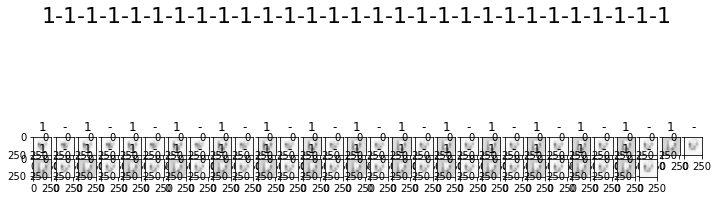

In [71]:
# captions on the validation set
result, attention_plot = evaluate(image_train[1], max_length_test)

print ('Real Caption:', caption_train[1])
print ('Prediction Caption:', ''.join(result[:-1]))

plot_attention(image_train[1], result, attention_plot)

# WER, MER, WIL, WIP

- WER = Word Error Rate
- MER = Match Error Rate
- WIL = Word Information Lost
- WIP = Word Information Preserved

In [72]:
import jiwer

transformation = jiwer.Compose([
    jiwer.ToLowerCase(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.RemoveWhiteSpace(replace_by_space=False),
    jiwer.SentencesToListOfWords(word_delimiter=" ")
]) 

In [73]:
ground_truth, _ = kme_segment.word_segmentation(caption_test[0])
hypothesis, _ = evaluate(image_test[0], max_length_test)
score = jiwer.compute_measures(
    ground_truth,
    hypothesis[:-1], 
    truth_transform=transformation, 
    hypothesis_transform=transformation
)

print(ground_truth)
print(hypothesis[:-1])
print(score)

['deca', '-', '3', ',', '4', '-', 'di', 'ene']
['2', '-', '2', '-', '1', '-', '1', '-', '1', '-', 'di', 'meth', 'yl', '-', '1', '-', 'di', 'meth', 'yl', '-', '1', '-', 'di', 'meth', 'yl', '-', '1', '-', 'di', 'meth', 'yl', '-', '1', '-', 'di', 'meth', 'yl', 'hex', '-', 'di', 'meth', 'yl', '-', '1', '-', 'di', 'meth', 'yl', '-', '1', '-', 'di', 'meth', 'yl', 'hex', '-', 'di']
{'wer': 6.75, 'mer': 0.9473684210526315, 'wil': 0.9802631578947368, 'wip': 0.019736842105263157, 'hits': 3, 'substitutions': 5, 'deletions': 0, 'insertions': 49}


# BLEU SCORE

In [74]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

## All Bleu Score

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nami.AI.kme_tokenize import Segmentation

kme_segment = Segmentation()
score1, score2, score3, score4 = [], [], [], []
best_score = {}
chencherry = SmoothingFunction()

for i in trange(len(image_test)):
  word_arr, _ = evaluate(image_test[i], max_length_test)

  real_word,_ = kme_segment.word_segmentation(caption_test[i])
  try:
      score1 = np.concatenate((score3, [sentence_bleu([real_word], word_arr[:-1], weights=(1.0, 0, 0, 0), smoothing_function = chencherry.method4)]))
      score2 = np.concatenate((score3, [sentence_bleu([real_word], word_arr[:-1], weights=(0.5, 0.5, 0, 0), smoothing_function = chencherry.method4)]))
      score3 = np.concatenate((score3, [sentence_bleu([real_word], word_arr[:-1], weights=(0.3, 0.3, 0.3, 0), smoothing_function = chencherry.method4)]))
      score4 = np.concatenate((score4, [sentence_bleu([real_word], word_arr[:-1], weights=(0.25, 0.25, 0.25, 0.25), smoothing_function = chencherry.method4)]))
  except :
    None

In [76]:
print(f"BLEU1 {np.mean(score1)*100}\n"
      f"BLEU2 {np.mean(score2)*100}\n"
      f"BLEU3 {np.mean(score3)*100}\n"
      f"BLEU4 {np.mean(score4)*100}\n"
      )

BLEU1 11.106412649152462
BLEU2 11.098678841449926
BLEU3 11.094130839545574
BLEU4 11.583862693591236



In [77]:
best_score = {}
chencherry = SmoothingFunction()

for i in trange(len(image_test)):
  word_arr, _ = evaluate(image_test[i], max_length_test)
  real_word,_ = kme_segment.word_segmentation(caption_test[i])
  
  try:
      score = sentence_bleu([real_word], word_arr[:-1], smoothing_function = chencherry.method4)
      best_score[i] = score
  except :
      None
  #print(f"{i} | {score:.4f}", end=' ')
  #print(''.join(word_arr[:-1]), end=' : ')
  #print(caption_test[i])

In [ ]:
sort_best_score = sorted(best_score.items(), key=lambda x: x[1], reverse=True)

In [ ]:
for i in range(30):
  print(sort_best_score[i][0], sort_best_score[i][1])

# Example

In [ ]:
# captions on the validation set
result, attention_plot = evaluate(image_test[144], max_length_test)

print ('Real Caption:', caption_test[144])
print ('Prediction Caption:', ''.join(result[:-1]))
plt.imshow(image_test[144])
plt.show()
plot_attention(image_test[144], result, attention_plot)


In [ ]:
# captions on the validation set
result, attention_plot = evaluate(image_test[38], max_length_test)

print ('Real Caption:', caption_test[38])
print ('Prediction Caption:', ''.join(result[:-1]))
plt.imshow(image_test[38])
plt.show()
plot_attention(image_test[38], result, attention_plot)


In [ ]:
# captions on the validation set
result, attention_plot = evaluate(image_train[282], max_length_train)

print ('Real Caption:', caption_train[282])
print ('Prediction Caption:', ''.join(result[:-1]))
plt.imshow(image_train[282])
plt.show()
plot_attention(image_train[282], result, attention_plot)


In [ ]:
plt.imshow(image_train[0,:,:,0], cmap='gray')

In [ ]:
# captions on the validation set
result, attention_plot = evaluate(image_test[270], max_length_test)

print ('Real Caption:', caption_test[270])
print ('Prediction Caption:', ''.join(result[:-1]))
plt.imshow(image_test[270])
plt.show()
plot_attention(image_test[270], result, attention_plot)
